# LSTM Preprocessing: creating the loss graph to estimate the number of epoches needed

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers

import tensorflow as tf
from scikeras.wrappers import KerasRegressor

# On avge, 252 trading days a year
NUM_TRADING_DAYS = 252

# Generate random w (diff. portfolios)
NUM_PORTFOLIOS = 10000

# Our portfolio stocks
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# Historical data - define START, END dates
start_date = '2010-01-01'
end_date = '2023-10-01'

In [2]:
# merged df: financial indicators merged with sentiment score based on date

merged = pd.read_excel("merged.xlsx", index_col=0)

stock_dict = {}
for stock in stocks:
    new_df = merged.filter(regex=f'{stock}_')
    stock_dict[f"{stock}"] = new_df

In [3]:
# LSTM model incorporates 4 features as picked out by XGBoost

def LSTM_model(key, stock_df):
    training_list = [f"{key}_Daily_Return", f"{key}_Adj Close", f"{key}_Volume", f"{key}_Sentiment_score"]
    trunc_df = stock_df.loc[:, training_list]
    stock_values = stock_df.loc[:, training_list].values

    # scaling features to be between 0 and 1
    sc = MinMaxScaler(feature_range=(0,1))
    stock_values = sc.fit_transform(stock_values)

    X = []
    y = []
    length = len(stock_values)

    # 60 days window: use previous 60-day data points to predict 4 features as listed above
    sequence_length = 60

    for i in range(length - sequence_length):
        X.append(stock_values[i:i + sequence_length])
        y.append(stock_values[i + sequence_length])

    X, y = np.array(X), np.array(y)

    # cannot use train test split due to time series data
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    # initialise LSTM model
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, 4)))
    # Dense(4) because we are predicting 4 features
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train,y_train, epochs=50, batch_size=100, verbose=0)

    y_pred = model.predict(X_test)

    # only interested in adj close
    y_test_slice = y_test[:,1] #MinMaxScaled
    y_pred_slice = y_pred[:,1] #MinMaxScaled

    # scale data back to original
    y_pred = sc.inverse_transform(y_pred)
    return history, np.sqrt(mean_squared_error(y_test_slice, y_pred_slice))




2023-11-06 14:39:33.373271: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-06 14:39:33.373290: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-06 14:39:33.373296: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-06 14:39:33.373350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-06 14:39:33.373381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-06 14:39:34.134546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:39:34.244985: I t

21/22 [===========================>..] - ETA: 0s

2023-11-06 14:39:59.330197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:39:59.367279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 6ms/step


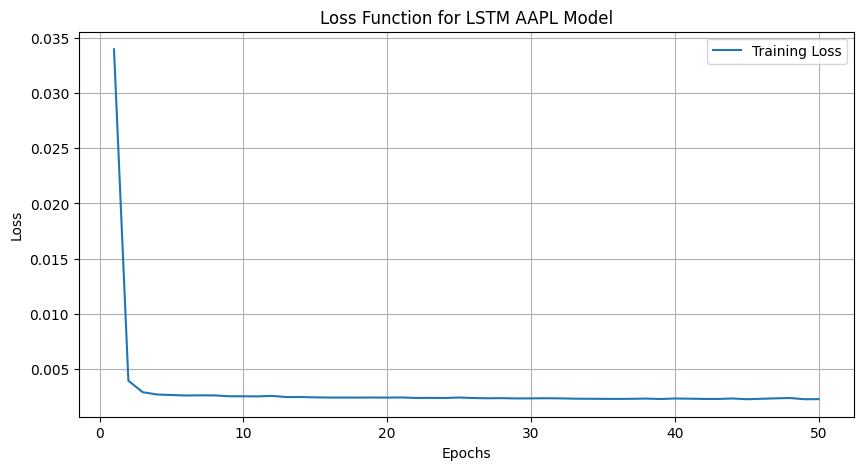

AAPL mse: 0.024798850115898993


2023-11-06 14:40:00.278546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:40:00.379902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:40:00.453279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 5ms/step


2023-11-06 14:40:25.654782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:40:25.689938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


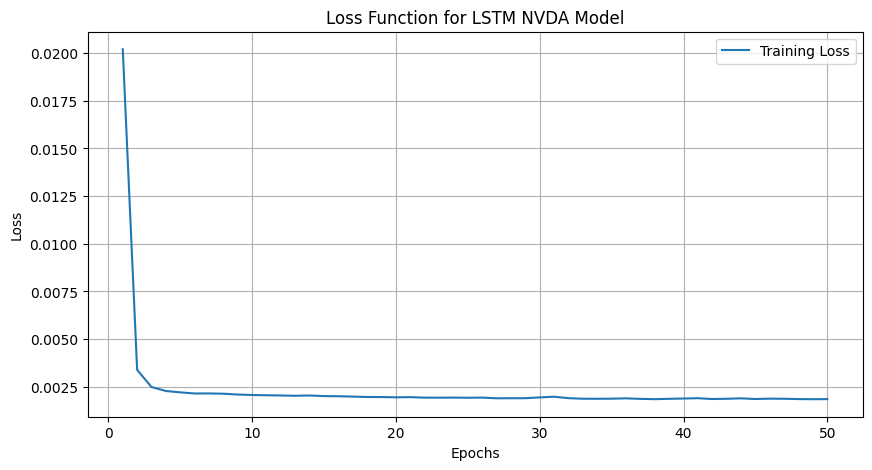

NVDA mse: 0.031021226891808456


2023-11-06 14:40:26.438156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:40:26.547523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:40:26.626598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 4ms/step


2023-11-06 14:40:51.353483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:40:51.386876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


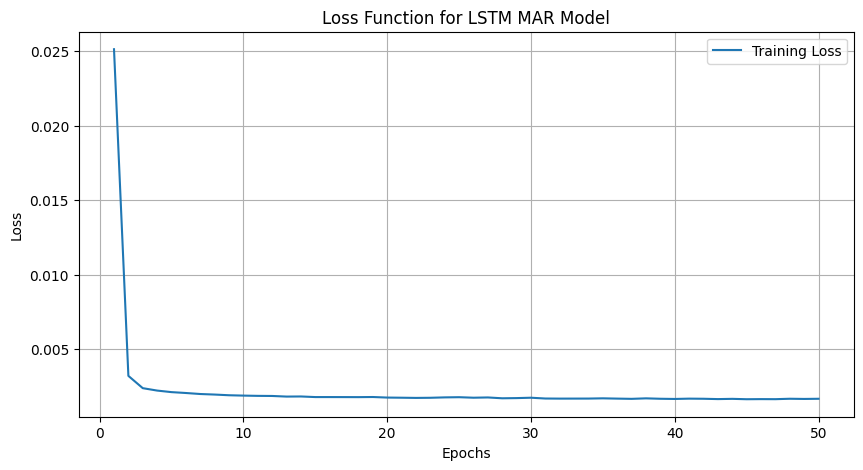

MAR mse: 0.021022805360316744


2023-11-06 14:40:52.220846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:40:52.321279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:40:52.391834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 5ms/step


2023-11-06 14:41:17.403353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:41:17.436899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


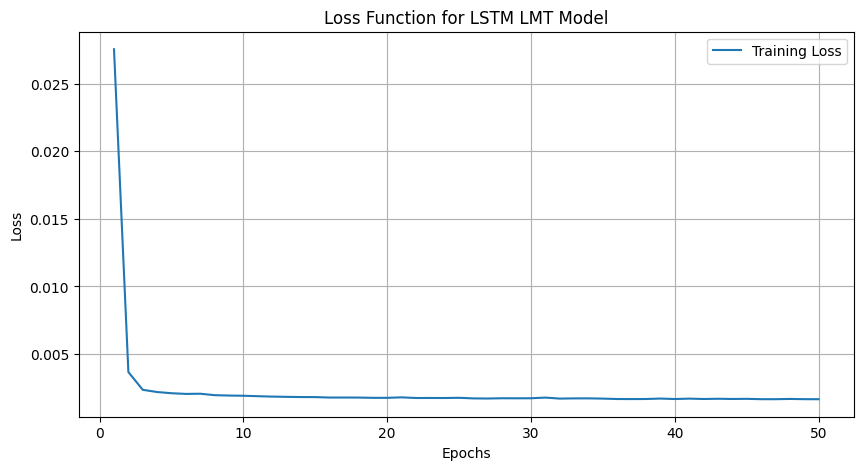

LMT mse: 0.016231622672616144


2023-11-06 14:41:18.150057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:41:18.252678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:41:18.334685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/22 [====================>.........] - ETA: 0s

2023-11-06 14:41:42.801807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 14:41:42.835164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 7ms/step


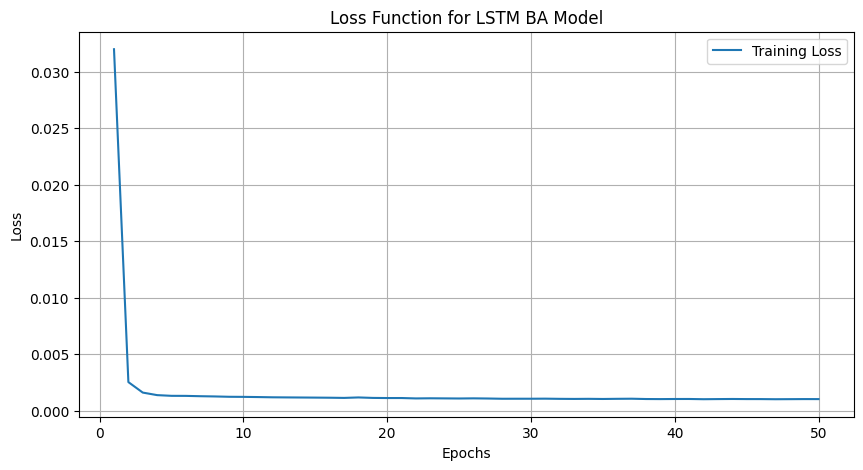

BA mse: 0.01644223098604376


In [4]:
for key in stock_dict.keys():
    stock_df = stock_dict[key]
    history, mse = LSTM_model(key, stock_df)

    training_loss = history.history['loss']
    epochs = range(1, len(training_loss) + 1)

    # Plot the loss function
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.title(f'Loss Function for LSTM {key} Model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{key} mse: {mse}")
    
    # as shown, optimal number of epoches is between 1-10
    # as epoch goes beyond 10, risk of overfitting increases
